In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from pprint import pprint

from warnings import filterwarnings
filterwarnings('ignore')

#### Helper Functions

In [24]:
def model_and_evaluate(mode, plot=False):
    
    # Names of models
    model_labels = [
        'LinearRegression',
          'Lasso',
          'Ridge',
          'DecisionTreeRegressor',
          'KNeighborsRegressor',
          'MLPRegressor',
          'RandomForestRegressor',
          'XGBRegressor',
          'XGBRFRegressor', 
          'SVR', 
          'AdaBoostRegressor'            
         ]

    # Regression Models with default hyper-parameters
    models = [
        LinearRegression(),
          Lasso(alpha=0.001),
          Ridge(),
          DecisionTreeRegressor(),
          KNeighborsRegressor(weights='distance'),
          MLPRegressor(random_state=42, max_iter=2000),
          RandomForestRegressor(),
          XGBRegressor(objective='reg:squarederror'),
          XGBRFRegressor(objective='reg:squarederror', learning_rate=1), 
          SVR(C=500000), 
          AdaBoostRegressor()
    ]

    r2_scores = []
    mse_scores = []
    mae_scores = []

    for i, (model, name) in enumerate(zip(models, model_labels)):

        model.fit(X_train, y_train)
        
        if mode == 'train':
            y_pred = model.predict(X_train)
            evaluation = y_train
#             print("On Training Data")
        elif mode == 'test':
            y_pred = model.predict(X_test)
            evaluation = y_test
#             print("On Testing Data")


        r2_scores.append(round(metrics.r2_score(evaluation, y_pred), 4))
        mse_scores.append(metrics.mean_squared_error(evaluation, y_pred))
        mae_scores.append(metrics.mean_absolute_error(evaluation, y_pred))  
        
        if plot:
            plt.scatter(evaluation, y_pred)
            plt.xlabel("True Labels")
            plt.ylabel("Predictions")
            plt.title(name)
            plt.show()
        
    evaluation_df = pd.DataFrame({"model" : model_labels,
                                  "R-squared": r2_scores, 
                                  "MSE" : mse_scores, 
                                  "MAE" : mae_scores}).sort_values(by=['R-squared'], ascending=False)
    
    
    
    return evaluation_df.reset_index(drop=True).set_index('model')

In [25]:
# Read dataset
data = pd.read_csv("../../Copper Dataset (version 2.0).csv")

# Split into features and target variables
X = data.iloc[:, -30 :-2]   # Only the composition columns
y = data['thermal_conductivity']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)  # (1029 in train/ 258 in test)

In [26]:
# Model using multiple techniques

# Evaluate on training data
train_eval = model_and_evaluate('train')
print(train_eval)

# Evaluate on testing data
test_eval = model_and_evaluate('test')
print(test_eval)

                       R-squared         MSE        MAE
model                                                  
DecisionTreeRegressor     0.9997    1.457726   0.116618
KNeighborsRegressor       0.9996    1.700680   0.106900
RandomForestRegressor     0.9983    7.258001   0.503378
XGBRegressor              0.9892   45.644742   3.907575
MLPRegressor              0.9425  243.937009   9.121148
AdaBoostRegressor         0.9307  293.694040  14.225240
XGBRFRegressor            0.9213  333.853770  12.161362
SVR                       0.9153  359.172107   8.356334
LinearRegression          0.8679  560.221683  17.587996
Lasso                     0.8628  581.747149  18.034524
Ridge                     0.8477  646.009197  18.938084
                       R-squared         MSE        MAE
model                                                  
DecisionTreeRegressor     0.9992    3.139535   0.201550
KNeighborsRegressor       0.9991    3.566251   0.193696
RandomForestRegressor     0.9963   15.051983   1

# Best Models

In [27]:
# Mask for models with R-squared score > 0.8
mask = test_eval['R-squared'] > 0.8
best_models = test_eval[mask].index.values

# Display names of the best performing models
print("Models with r-squared > 0.80 are :-\n")

for i, model_name in enumerate(best_models):
    print("{}. {}".format(i+1, model_name))

Models with r-squared > 0.80 are :-

1. DecisionTreeRegressor
2. KNeighborsRegressor
3. RandomForestRegressor
4. XGBRegressor
5. XGBRFRegressor
6. AdaBoostRegressor
7. MLPRegressor
8. SVR
9. LinearRegression
10. Lasso
11. Ridge


# Hyperparameter Tuning for each model

**1. Random Forest Regressor** 

a. Hyperparamter tuning with **RandomizedSearchCV**\
b. Hyperparamter tuning with **GridSearchCV**

#### Random Search Cross Validation

In [6]:
# Create grid for RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [7]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,   # 3 folds
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

We can view the **best parameters** from fitting the random search:

In [8]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

### Evaluate Random Search

To determine if random search yielded a better model, we **compare the base model** with the **best random search model**.

In [9]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    return accuracy


base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1.3853 degrees.
Accuracy = 98.92%.

Model Performance
Average Error: 1.8744 degrees.
Accuracy = 98.47%.

Improvement of -0.46%.


In [10]:
model_name = "Random Forest Regressor"
y_pred = best_random.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

,R-squared,MSE,MAE
Random Forest Regressor,0.993,28.430565,1.874439


In [11]:
# model = best_random 

# importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")
# labels = []
# for f in range(X_train.shape[1]):
# #     print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
#     labels.append(X_train.columns[indices[f]])

# # Plot the feature importances of the forest
# plt.figure(figsize=(10,20))
# plt.title("Feature importances")
# plt.barh(labels, importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.yticks(ticks=labels)
# plt.ylim([-1, X.shape[1]])
# plt.show()

#### Grid Search Cross Validation

To use Grid Search, we **make another grid based on the best values provided by random search**

In [12]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 3, 4, 5, 'auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [300, 400, 500, 600]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   29.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [13]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [14]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1.2455 degrees.
Accuracy = 98.92%.

Improvement of 0.00%.


In [15]:
model_name = "Random Forest Regressor (Grid Search)"
y_pred = best_grid.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

,R-squared,MSE,MAE
Random Forest Regressor (Grid Search),0.9916,34.289212,1.2455


In [16]:
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [400, 500, 600, 700, 800]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters
pprint(grid_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.6s finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}


In [17]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

model_name = "Random Forest Regressor (Grid Search v. 2)"
y_pred = best_grid.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

,R-squared,MSE,MAE
Random Forest Regressor (Grid Search v. 2),0.9878,49.901731,2.724469


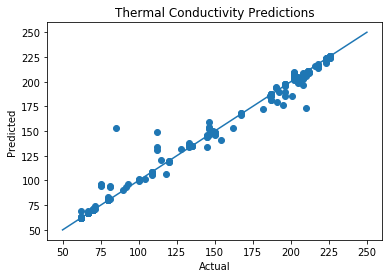

In [18]:
plt.scatter(y_test, y_pred)
plt.plot([50, 250], [50,250])
plt.title("Thermal Conductivity Predictions")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

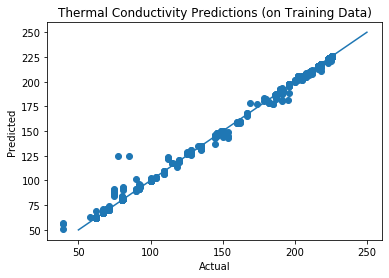

In [19]:
plt.scatter(y_train, best_grid.predict(X_train))
plt.plot([50, 250], [50,250])
plt.title("Thermal Conductivity Predictions (on Training Data)")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()